<center> <h1> <span style="color:black"> [BLOG POST 2]- Boost your model performance with Machine/Deep Learning</h1> </center> 
<center> <h2> <span style="color:red">Machine Learning in Actuarials  </h1> </center>
<center> <h3> <span style="color:black"> Author: Marino San Lorenzo </h1> </center>

# Agenda
* [Chapter 1 - Data Exploration](#one)
    + [1.1 univariate analysis of numerical data](#one-one)
    + [1.2 univariate analysis of categorical data](#one-two)
    + [1.3 bivariate analysis of numerical data](#one-three)
    + [1.4 bivariate analysis of categorical data](#one-four)
* [Chapter 2 - Feature Engineering](#two)
    + [2.1 Processing with Binning continuous variables](#two-one)
        + [2.1.1 Dummy Coding with reference class](#two-one-one)
* [Chapter 3 - Modelling](#three)
    + [3.1 Regression Trees](#three-one)
        + [3.1.1 No optimization](#three-one-one)
        + [3.1.2 Random Search - Scikit Learn](#three-one-two)
        + [3.1.3 Halving Random Search - Scikit Learn](#three-one-three)
        + [3.1.4 Random Search - Customed](#three-one-four)
        + [3.1.5 Bayesian - Mango](#three-one-five)
    + [3.2 Random Forest](#three-two)
        + [3.2.1 No optimization](#three-two-one)
        + [3.2.2 Random Search - Scikit Learn](#three-two-two)
        + [3.2.3 Halving Random Search - Scikit Learn](#three-two-three)
        + [3.2.4 Bayesian - Mango](#three-two-four)
        + [3.2.5 Random Search - Customed](#three-two-five)
    + [3.3 Gradient Boosting ](#three-three)
        + [3.2.1 No optimization](#three-three-one)
        + [3.2.2 Random Search - Scikit Learn](#three-three-two)
        + [3.2.3 Halving Random Search - Scikit Learn](#three-three-three)
        + [3.2.4 Bayesian - Mango](#three-three-four)
        + [3.2.5 Random Search - Customed](#three-three-five)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from src.constants import Constants, params, Constants2, params_blog_2
from typing import *
from src.styling import *
from src.utils import *
from src.plots import *
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import warnings
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from collections import defaultdict
from matplotlib import cm
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz
from sklearn.experimental import enable_halving_search_cv # get the experimental version of halving search working
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
from functools import partial
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from mango import Tuner
import time


In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format','{:,.2f}'.format)
plt.style.use('ggplot')

In [3]:
TEST_SIZE, VAL_SIZE, RANDOM_STATE = params.get(Constants.TEST_SIZE),params.get(Constants.VAL_SIZE), params.get(Constants.RANDOM_STATE)
nb_claims_name, claim_amount_name = params_blog_2.get(Constants2.NB_CLAIMS), params_blog_2.get(Constants2.CLAIM_AMOUNT)
claim_frequency_name = params_blog_2.get(Constants2.CLAIM_FREQUENCY)
exposure_name = params_blog_2.get(Constants2.EXPOSURE_NAME)
N_ITER_SKLEARN_HYPEROPT = params_blog_2.get(Constants2.N_ITER_SKLEARN_HYPEROPT)
N_ITER= N_ITER_SKLEARN_HYPEROPT

In [4]:
df_freq = pd.read_csv(os.path.join(params_blog_2.get(Constants2.PATH_TO_DATA), 'freMTPLfreq.csv'))
df_sev = pd.read_csv(os.path.join(params_blog_2.get(Constants2.PATH_TO_DATA), 'freMTPLsev.csv'))

In [5]:
df_freq.head(2)

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76


In [6]:
df_sev.head(2)

,PolicyID,ClaimAmount
0,63987,1172
1,310037,1905


In [7]:
df_freq.shape

(413169, 10)

In [8]:
df_sev.shape

(16181, 2)

In [9]:
# here we need to merge the claim amounts 

In [10]:
policy_id_of_policies_with_claims_amount = df_sev.PolicyID.to_list()

In [11]:
policy_id_of_policies_without_claims_amount = set(df_freq.PolicyID) - set(policy_id_of_policies_with_claims_amount)

In [12]:
df_sev_extension_without_claims = pd.DataFrame()
df_sev_extension_without_claims['PolicyID'] = list(policy_id_of_policies_without_claims_amount)
df_sev_extension_without_claims[claim_amount_name] = 0

In [13]:
df_sev_extended = pd.concat([df_sev, df_sev_extension_without_claims], axis=0)

In [14]:
df_sev_agg = pd.DataFrame(df_sev_extended.groupby('PolicyID')['ClaimAmount'].sum())
df_sev_agg.reset_index(drop=False)

,PolicyID,ClaimAmount
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
413164,413165,0
413165,413166,0
413166,413167,0
413167,413168,0


In [15]:
df_sev_agg.shape[0]

413169

In [16]:
df_freq.shape

(413169, 10)

In [17]:
df = pd.merge(df_freq, df_sev_agg, how='left', on='PolicyID')

In [18]:
df[claim_frequency_name] = df[nb_claims_name]/df[exposure_name]

In [19]:
df

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount,claim_frequency
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0,0.00
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0,0.00
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
413164,413165,0,0.00,j,0,29,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,2471,0,0.00
413165,413166,0,0.01,d,0,29,Japanese (except Nissan) or Korean,Regular,Ile-de-France,5360,0,0.00
413166,413167,0,0.01,k,0,49,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,5360,0,0.00
413167,413168,0,0.00,d,0,41,Japanese (except Nissan) or Korean,Regular,Ile-de-France,9850,0,0.00


# 1. Data Exploration <a name="one"></a>

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413169 entries, 0 to 413168
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PolicyID         413169 non-null  int64  
 1   ClaimNb          413169 non-null  int64  
 2   Exposure         413169 non-null  float64
 3   Power            413169 non-null  object 
 4   CarAge           413169 non-null  int64  
 5   DriverAge        413169 non-null  int64  
 6   Brand            413169 non-null  object 
 7   Gas              413169 non-null  object 
 8   Region           413169 non-null  object 
 9   Density          413169 non-null  int64  
 10  ClaimAmount      413169 non-null  int64  
 11  claim_frequency  413169 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 41.0+ MB


In [21]:
summary = df.describe()
summary.style.applymap(highlight_col, subset=pd.IndexSlice[['mean', 'max'], [params.get(Constants.NB_CLAIMS)]])
summary

,PolicyID,ClaimNb,Exposure,CarAge,DriverAge,Density,ClaimAmount,claim_frequency
count,"413,169.00","413,169.00","413,169.00","413,169.00","413,169.00","413,169.00","413,169.00","413,169.00"
mean,"206,585.00",0.04,0.56,7.53,45.32,"1,985.15",83.42,0.12
std,"119,271.76",0.20,0.37,5.76,14.33,"4,776.25","4,192.53",2.16
min,1.00,0.00,0.00,0.00,18.00,2.00,0.00,0.00
25%,"103,293.00",0.00,0.20,3.00,34.00,67.00,0.00,0.00
50%,"206,585.00",0.00,0.54,7.00,44.00,287.00,0.00,0.00
75%,"309,877.00",0.00,1.00,12.00,54.00,"1,410.00",0.00,0.00
max,"413,169.00",4.00,1.99,100.00,99.00,"27,000.00","2,036,833.00",365.00


In [22]:
pd.cut(df[claim_amount_name], bins= [0, 50_000, 100_000, 500_000]).value_counts()

(0, 50000]          15331
(50000, 100000]        35
(100000, 500000]       22
Name: ClaimAmount, dtype: int64

In [23]:
df[[exposure_name, nb_claims_name, claim_amount_name]].describe()

,Exposure,ClaimNb,ClaimAmount
count,"413,169.00","413,169.00","413,169.00"
mean,0.56,0.04,83.42
std,0.37,0.20,"4,192.53"
min,0.00,0.00,0.00
25%,0.20,0.00,0.00
50%,0.54,0.00,0.00
75%,1.00,0.00,0.00
max,1.99,4.00,"2,036,833.00"


In [24]:
# check how many categories for categorical variables
info_categories = get_distribution_info_for_categorical_variables(df)
info_categories

,nb_unique_categories,distribution
Power,12,"{'f': '23.17%', 'g': '22.07%', 'e': '18.64%', 'd': '16.46%', 'h': '6.46%', 'j': '4.37%', 'i': '4.26%', 'k': '2.31%', 'l': '1.13%', 'm': '0.44%', 'o': '0.36%', 'n': '0.32%'}"
Brand,7,"{'Renault, Nissan or Citroen': '52.81%', 'Japanese (except Nissan) or Korean': '19.14%', 'Opel, General Motors or Ford': '9.05%', 'Volkswagen, Audi, Skoda or Seat': '7.90%', 'Mercedes, Chrysler or BMW': '4.67%', 'Fiat': '4.05%', 'other': '2.39%'}"
Gas,2,"{'Regular': '50.15%', 'Diesel': '49.85%'}"
Region,10,"{'Centre': '38.87%', 'Ile-de-France': '16.89%', 'Bretagne': '10.19%', 'Pays-de-la-Loire': '9.38%', 'Aquitaine': '7.58%', 'Nord-Pas-de-Calais': '6.60%', 'Poitou-Charentes': '4.61%', 'Basse-Normandie': '2.64%', 'Haute-Normandie': '2.13%', 'Limousin': '1.11%'}"


## 1.1 univariate analysis of numerical data <a name="one-one"></a>

In [25]:
numerical_variables = list(df.select_dtypes(exclude=['object']).columns)
numerical_variables

['PolicyID',
 'ClaimNb',
 'Exposure',
 'CarAge',
 'DriverAge',
 'Density',
 'ClaimAmount',
 'claim_frequency']

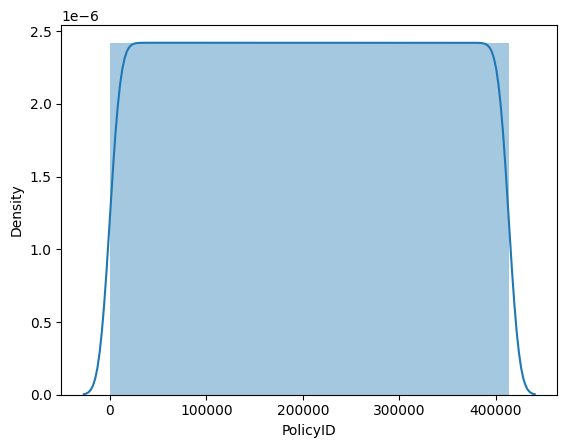

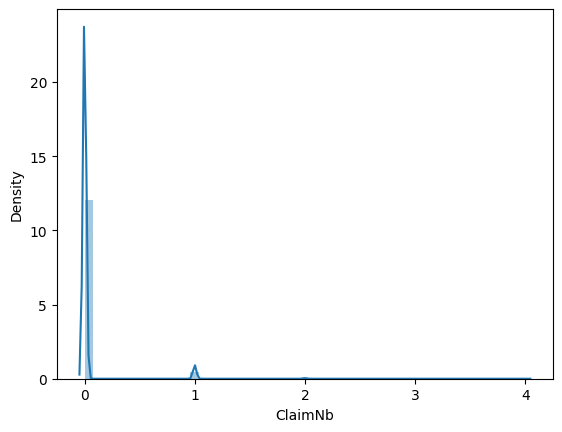

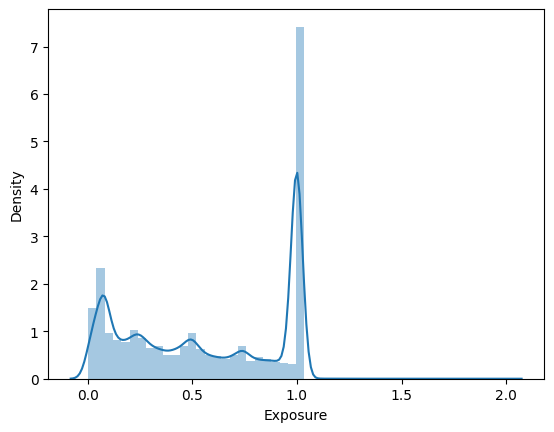

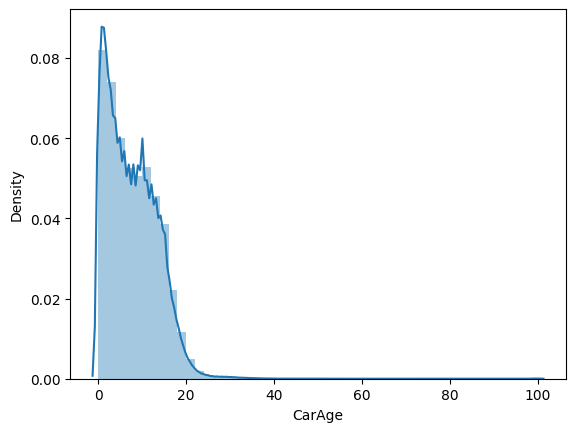

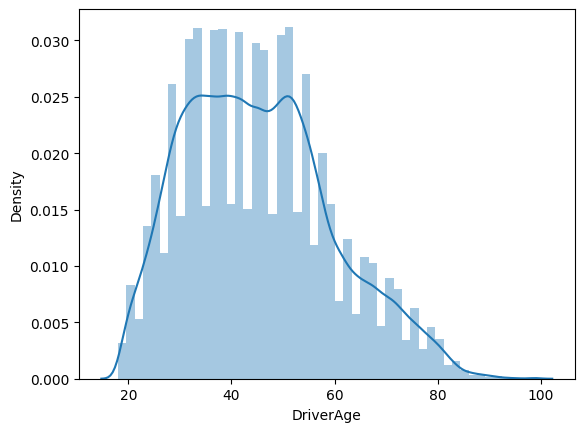

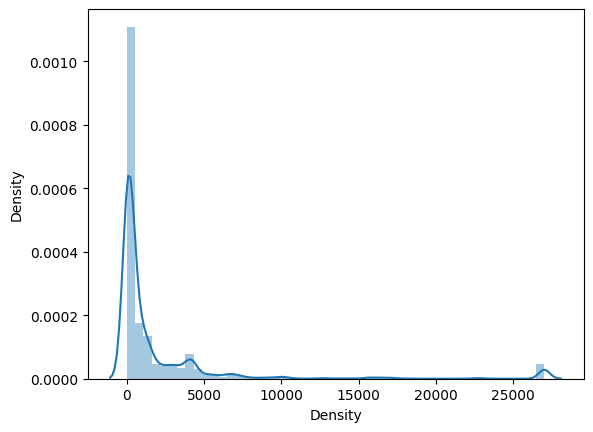

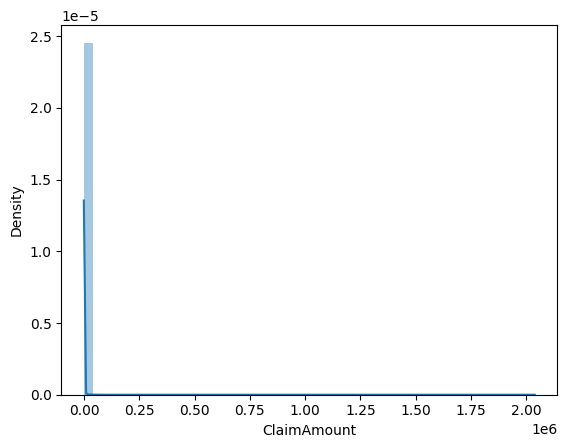

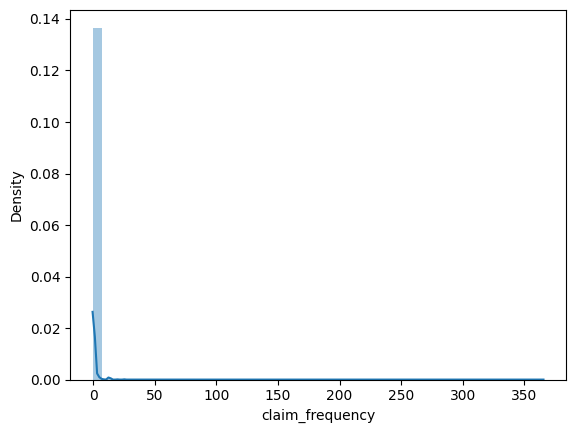

In [26]:
plot_univariate_numerical_variables_distribution(df, numerical_variables, params)

In [27]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,PolicyID,ClaimNb,Exposure,CarAge,DriverAge,Density,ClaimAmount,claim_frequency
PolicyID,1.000000,-0.034709,-0.132262,-0.078895,0.048708,0.102285,-0.005414,-0.006713
ClaimNb,-0.034709,1.000000,0.076039,0.004506,-0.006128,0.005163,0.107303,0.282522
Exposure,-0.132262,0.076039,1.000000,0.140104,0.194260,-0.112349,0.002238,-0.034530
CarAge,-0.078895,0.004506,0.140104,1.000000,-0.046414,-0.142318,0.001642,0.005092
DriverAge,0.048708,-0.006128,0.194260,-0.046414,1.000000,-0.001692,-0.004549,-0.015203
Density,0.102285,0.005163,-0.112349,-0.142318,-0.001692,1.000000,-0.001321,0.001829
ClaimAmount,-0.005414,0.107303,0.002238,0.001642,-0.004549,-0.001321,1.000000,0.044436
claim_frequency,-0.006713,0.282522,-0.034530,0.005092,-0.015203,0.001829,0.044436,1.000000


We notice that `nbrtotc` and `nbrtotan` are highly correlated (the same goes for `duree` and `lnexpo`)

## 1.2 univariate analysis of categorical data <a name="one-two"></a>

In [28]:
categorical_variables = list(df.select_dtypes(include=['object']).columns)
categorical_variables

['Power', 'Brand', 'Gas', 'Region']

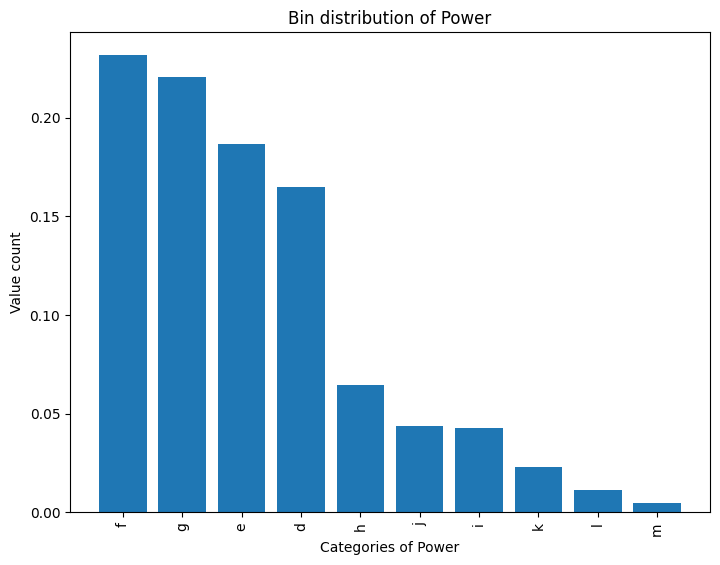

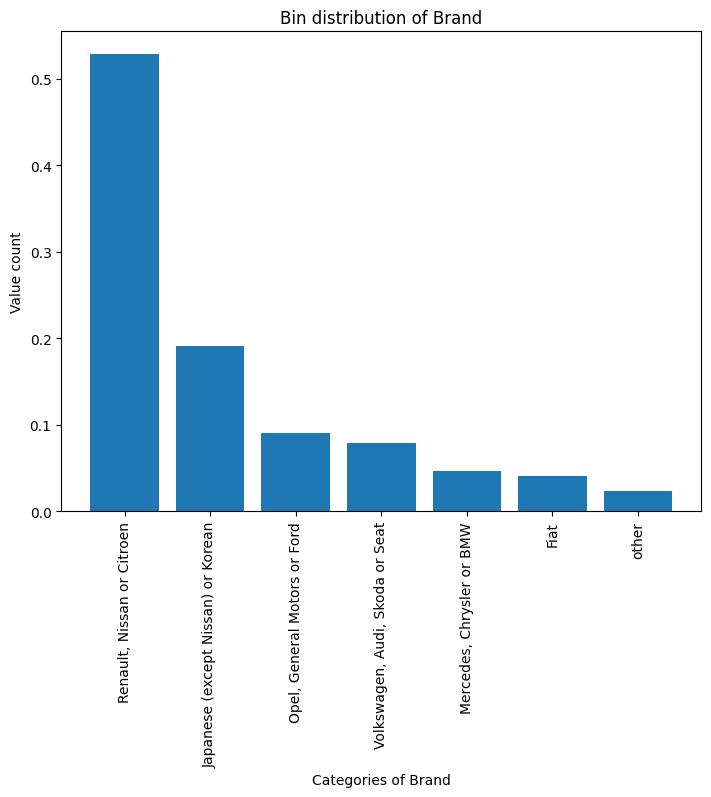

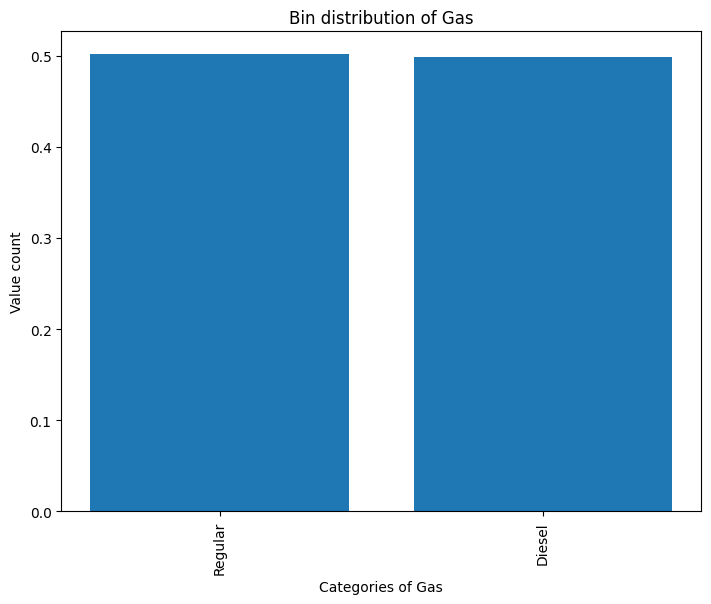

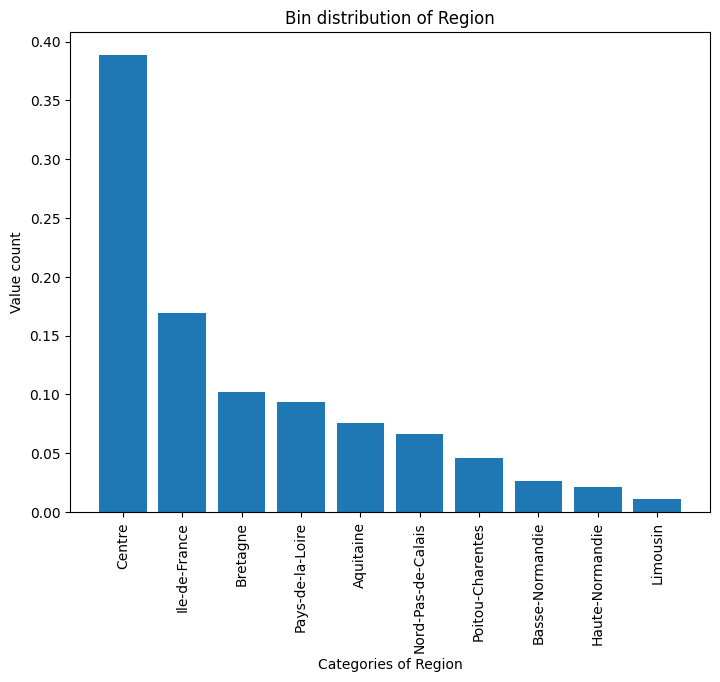

In [29]:
plot_univariate_categorical_variables_distribution(df, categorical_variables, params)

## 1.3 bivariate analysis of numerical data <a name="one-three"></a>

In [30]:
df[claim_frequency_name] = df[nb_claims_name]/df[exposure_name]

In [31]:
df[[claim_frequency_name, exposure_name, nb_claims_name, claim_amount_name]].describe()

,claim_frequency,Exposure,ClaimNb,ClaimAmount
count,"413,169.00","413,169.00","413,169.00","413,169.00"
mean,0.12,0.56,0.04,83.42
std,2.16,0.37,0.20,"4,192.53"
min,0.00,0.00,0.00,0.00
25%,0.00,0.20,0.00,0.00
50%,0.00,0.54,0.00,0.00
75%,0.00,1.00,0.00,0.00
max,365.00,1.99,4.00,"2,036,833.00"


In [32]:
weighted_claim_frequency = df.groupby(nb_claims_name)[nb_claims_name, exposure_name, claim_frequency_name].agg(nb_claims=(nb_claims_name, 'count'),\
                                                                                    exposure=(exposure_name, 'sum'),
                                                                                    sum_claims=(nb_claims_name, 'sum'))
weighted_claim_frequency['weighted_mean_frequency'] = weighted_claim_frequency['sum_claims']/weighted_claim_frequency['exposure']
weighted_claim_frequency

,nb_claims,exposure,sum_claims,weighted_mean_frequency
ClaimNb,,,,
0,397779,"220,936.42",0,0.00
1,14633,"10,348.44",14633,1.41
2,726,519.70,1452,2.79
3,28,18.67,84,4.50
4,3,0.93,12,12.90


In [33]:
feature = 'DriverAge'
binned_feature = f'{feature}_binned'
df_cp = df.copy()
df_cp[binned_feature] = pd.qcut(df[feature], q=10, precision=0, duplicates="drop")
weighted_claim_freq = df_cp.groupby(binned_feature).agg(sum_claims=(nb_claims_name, 'sum'), exposure = (exposure_name, 'sum'))

In [34]:
weighted_claim_freq['weighted_claim_frequency'] = weighted_claim_freq['sum_claims']/weighted_claim_freq['exposure']

In [35]:
weighted_claim_freq

,sum_claims,exposure,weighted_claim_frequency
DriverAge_binned,,,
"(17.0, 28.0]",2466,"21,334.74",0.12
"(28.0, 32.0]",1316,"18,889.39",0.07
"(32.0, 36.0]",1396,"21,433.69",0.07
"(36.0, 40.0]",1423,"22,528.19",0.06
"(40.0, 44.0]",1571,"22,573.08",0.07
"(44.0, 48.0]",1624,"22,458.65",0.07
"(48.0, 52.0]",1743,"24,333.20",0.07
"(52.0, 57.0]",1651,"25,880.37",0.06
"(57.0, 66.0]",1470,"25,071.60",0.06


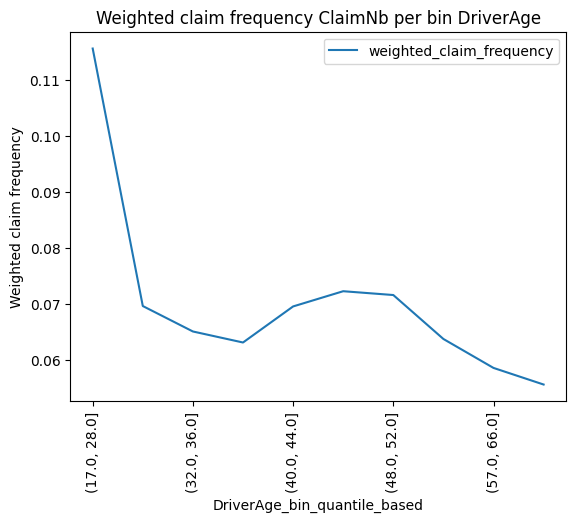

In [36]:
plot_avg_target_per_numerical_bin(df, ['DriverAge'], params_blog_2, target=nb_claims_name,exposure_name=exposure_name)

**Some observations:**

- The variable `AGEPH` is almost monotonically decreasing, we observe a small bump between 41 and 55 yo.

## 1.4 bivariate analysis of categorical data <a name="one-four"></a>

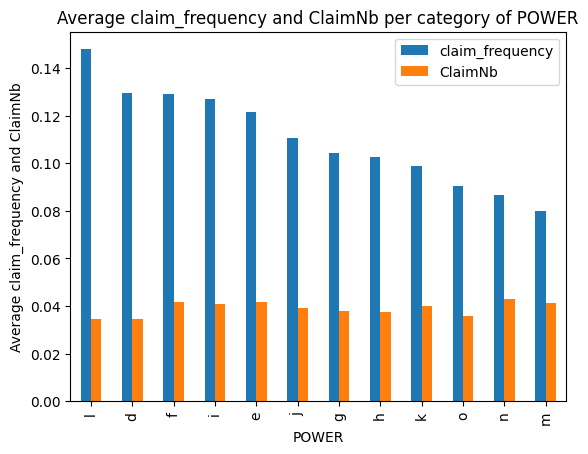

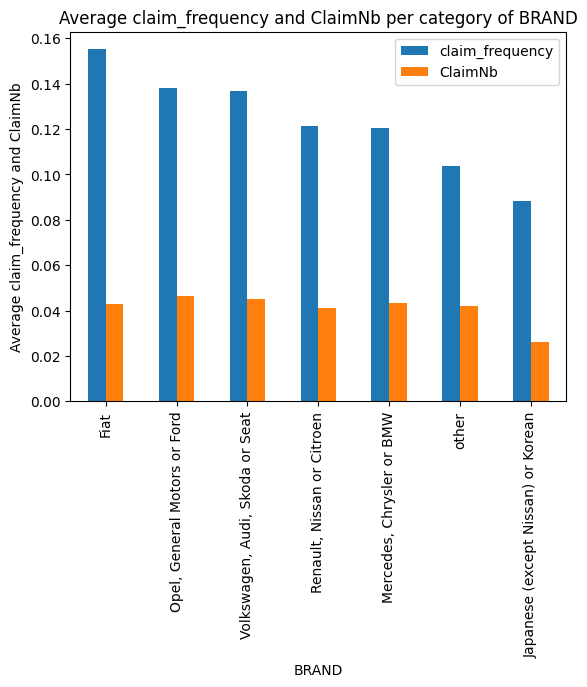

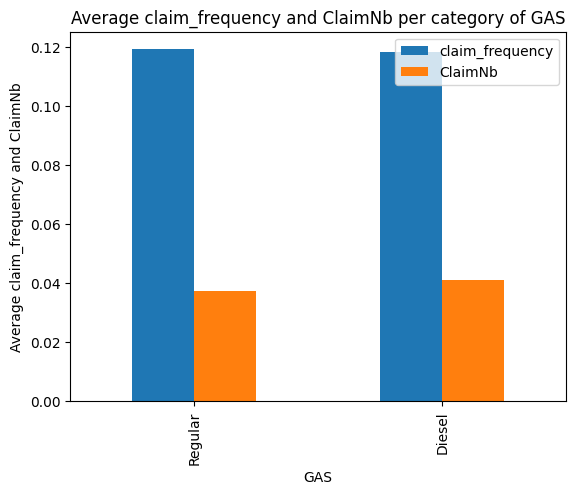

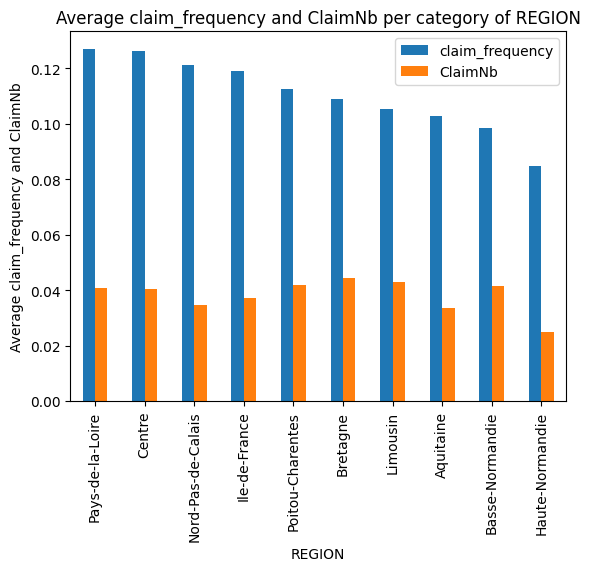

In [37]:
plt_avg_target_per_category(df, categorical_variables, params_blog_2, target=claim_frequency_name)

**Some observations:**

- Difficult to interpret anything based on the `CODPOSS`, later on we will try to map this data to district information 
- `AGECAR`: it looks like it has a slight monotonic decreasing relationship between the claim frequency and `AGECAR`
- `SEXP_female` is slightly riskier group than `SEXP_male` when took alone.
- `FUELC_petrol` is slightly less risky group than `FUELC_gasoil` when took alone.
- `SPLIT`: Policyholders who pay their coverage by Thrice are riskier tham the Once.
- `USEC`: Professional and Private use do not seem to be significantly different.
- `FLEETC`: The fleet group is less risky.
- `SPORTC`: The sport group is riskier.
- `COVERP`: difficult to draw any conclusions.
- `POWERC`: It looks like the more power, the riskier although it is not absolutely clear.

In [38]:
for cat_var in categorical_variables:
    print(df.groupby(cat_var)[[claim_frequency_name,nb_claims_name, claim_amount_name]].mean().sort_values(by=[nb_claims_name, claim_amount_name], ascending=False))
    print('-'*100)

       claim_frequency  ClaimNb  ClaimAmount
Power                                       
n                 0.09     0.04        75.45
f                 0.13     0.04       100.29
e                 0.12     0.04        72.49
m                 0.08     0.04       109.29
i                 0.13     0.04       185.67
k                 0.10     0.04        75.52
j                 0.11     0.04        76.18
g                 0.10     0.04        77.22
h                 0.10     0.04        64.94
o                 0.09     0.04        50.38
d                 0.13     0.03        65.78
l                 0.15     0.03        62.52
----------------------------------------------------------------------------------------------------
                                    claim_frequency  ClaimNb  ClaimAmount
Brand                                                                    
Opel, General Motors or Ford                   0.14     0.05        79.46
Volkswagen, Audi, Skoda or Seat                

# 2. Feature Engineering <a name="two"></a>

We decide to work only with categorical variables in order for faciliate the interpretation. 

In [39]:
for cat_var in categorical_variables:
    df[cat_var] = pd.Categorical(df[cat_var])
for num_var in numerical_variables:
    df[num_var] = pd.to_numeric(df[num_var])

In [40]:
df

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount,claim_frequency
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0,0.00
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0,0.00
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
413164,413165,0,0.00,j,0,29,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,2471,0,0.00
413165,413166,0,0.01,d,0,29,Japanese (except Nissan) or Korean,Regular,Ile-de-France,5360,0,0.00
413166,413167,0,0.01,k,0,49,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,5360,0,0.00
413167,413168,0,0.00,d,0,41,Japanese (except Nissan) or Korean,Regular,Ile-de-France,9850,0,0.00


In order for our algorithm/model to correctly read the information we feed it, the data needs to be numerically encoded. To keep things simple, suppose we had a vector of the age of policyholder as follow with minimum and maximum age going from 0 to 100:

age = (90, 20, 30, 60, 79)

We apply quantile binning method such that such vector will be transformed in such a matrice:


In [41]:
age_transformed = pd.DataFrame.from_dict({'[0-20)':[0,0,0,0,0],
                                          '[20-40)':[0, 1, 1, 0,0],
                                        '[40-60)':[0,0,0,0,0],
                                        '[60-80)':[0,0,0,1,1],
                                        '[80-100]':[1,0,0,0,0]})

In [42]:
age_transformed.index = [90, 20, 30, 60, 79]

In [43]:
age_transformed

,[0-20),[20-40),[40-60),[60-80),[80-100]
90,0,0,0,0,1
20,0,1,0,0,0
30,0,1,0,0,0
60,0,0,0,1,0
79,0,0,0,1,0


In [44]:
df.dtypes

PolicyID              int64
ClaimNb               int64
Exposure            float64
Power              category
CarAge                int64
DriverAge             int64
Brand              category
Gas                category
Region             category
Density               int64
ClaimAmount           int64
claim_frequency     float64
dtype: object

In [45]:
numerical_variables_to_bin = ['DriverAge', 'CarAge', 'Density']
for numerical_var in numerical_variables_to_bin:
    df = bin_numerical_variables(df, numerical_var, nb_bin=5)

In [46]:
df.head(2)

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount,claim_frequency,DriverAge_bin,CarAge_bin,Density_bin
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00,"(40.0, 48.0]","(-0.001, 2.0]","(51.0, 158.0]"
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00,"(40.0, 48.0]","(-0.001, 2.0]","(51.0, 158.0]"


In [47]:
df.CarAge_bin.replace({'(-0.001, 2.0]':'(0.0, 2.0]'}, inplace=True)

In [48]:
df.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount,claim_frequency,DriverAge_bin,CarAge_bin,Density_bin
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00,"(40.0, 48.0]","(0.0, 2.0]","(51.0, 158.0]"
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0,0.00,"(40.0, 48.0]","(0.0, 2.0]","(51.0, 158.0]"
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0,0.00,"(32.0, 40.0]","(0.0, 2.0]","(2404.0, 27000.0]"
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0,0.00,"(32.0, 40.0]","(0.0, 2.0]","(2404.0, 27000.0]"
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0,0.00,"(40.0, 48.0]","(0.0, 2.0]","(51.0, 158.0]"


In [49]:
df.dtypes

PolicyID              int64
ClaimNb               int64
Exposure            float64
Power              category
CarAge                int64
DriverAge             int64
Brand              category
Gas                category
Region             category
Density               int64
ClaimAmount           int64
claim_frequency     float64
DriverAge_bin      category
CarAge_bin         category
Density_bin        category
dtype: object

## 2.1 Processing with Binning continuous variables <a name="two-one"></a>

In [50]:
TEST_SIZE, RANDOM_STATE = params.get(Constants.TEST_SIZE), params.get(Constants.RANDOM_STATE)

In [51]:
df_cp = df.copy()

In [52]:
df.columns

Index(['PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge',
       'Brand', 'Gas', 'Region', 'Density', 'ClaimAmount', 'claim_frequency',
       'DriverAge_bin', 'CarAge_bin', 'Density_bin'],
      dtype='object')

In [53]:
non_predictor_variables = [*numerical_variables_to_bin,
                        *params_blog_2.get(Constants2.VARIABLES_TO_EXCLUDE)]

In [54]:
df_step1 =df.drop(columns=non_predictor_variables)

In [55]:
df_step1.columns

Index(['ClaimNb', 'Exposure', 'Power', 'Brand', 'Gas', 'Region', 'ClaimAmount',
       'claim_frequency', 'DriverAge_bin', 'CarAge_bin', 'Density_bin'],
      dtype='object')

In [56]:
df_step1.dtypes

ClaimNb               int64
Exposure            float64
Power              category
Brand              category
Gas                category
Region             category
ClaimAmount           int64
claim_frequency     float64
DriverAge_bin      category
CarAge_bin         category
Density_bin        category
dtype: object

In [57]:
get_distribution_info_for_categorical_variables(df_step1)

,nb_unique_categories,distribution
Power,12,"{'f': '23.17%', 'g': '22.07%', 'e': '18.64%', 'd': '16.46%', 'h': '6.46%', 'j': '4.37%', 'i': '4.26%', 'k': '2.31%', 'l': '1.13%', 'm': '0.44%', 'o': '0.36%', 'n': '0.32%'}"
Brand,7,"{'Renault, Nissan or Citroen': '52.81%', 'Japanese (except Nissan) or Korean': '19.14%', 'Opel, General Motors or Ford': '9.05%', 'Volkswagen, Audi, Skoda or Seat': '7.90%', 'Mercedes, Chrysler or BMW': '4.67%', 'Fiat': '4.05%', 'other': '2.39%'}"
Gas,2,"{'Regular': '50.15%', 'Diesel': '49.85%'}"
Region,10,"{'Centre': '38.87%', 'Ile-de-France': '16.89%', 'Bretagne': '10.19%', 'Pays-de-la-Loire': '9.38%', 'Aquitaine': '7.58%', 'Nord-Pas-de-Calais': '6.60%', 'Poitou-Charentes': '4.61%', 'Basse-Normandie': '2.64%', 'Haute-Normandie': '2.13%', 'Limousin': '1.11%'}"
DriverAge_bin,5,"{'(17.999, 32.0]': '21.08%', '(48.0, 57.0]': '20.42%', '(32.0, 40.0]': '20.07%', '(40.0, 48.0]': '19.34%', '(57.0, 99.0]': '19.10%'}"
CarAge_bin,5,"{'(0.0, 2.0]': '24.29%', '(5.0, 9.0]': '20.63%', '(9.0, 13.0]': '19.65%', '(2.0, 5.0]': '18.94%', '(13.0, 100.0]': '16.49%'}"
Density_bin,5,"{'(1.999, 51.0]': '20.17%', '(158.0, 555.0]': '20.00%', '(2404.0, 27000.0]': '20.00%', '(555.0, 2404.0]': '20.00%', '(51.0, 158.0]': '19.83%'}"


In [58]:
df_step1

,ClaimNb,Exposure,Power,Brand,Gas,Region,ClaimAmount,claim_frequency,DriverAge_bin,CarAge_bin,Density_bin
0,0,0.09,g,Japanese (except Nissan) or Korean,Diesel,Aquitaine,0,0.00,"(40.0, 48.0]","(0.0, 2.0]","(51.0, 158.0]"
1,0,0.84,g,Japanese (except Nissan) or Korean,Diesel,Aquitaine,0,0.00,"(40.0, 48.0]","(0.0, 2.0]","(51.0, 158.0]"
2,0,0.52,f,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,0,0.00,"(32.0, 40.0]","(0.0, 2.0]","(2404.0, 27000.0]"
3,0,0.45,f,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,0,0.00,"(32.0, 40.0]","(0.0, 2.0]","(2404.0, 27000.0]"
4,0,0.15,g,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,0,0.00,"(40.0, 48.0]","(0.0, 2.0]","(51.0, 158.0]"
...,...,...,...,...,...,...,...,...,...,...,...
413164,0,0.00,j,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,0,0.00,"(17.999, 32.0]","(0.0, 2.0]","(2404.0, 27000.0]"
413165,0,0.01,d,Japanese (except Nissan) or Korean,Regular,Ile-de-France,0,0.00,"(17.999, 32.0]","(0.0, 2.0]","(2404.0, 27000.0]"
413166,0,0.01,k,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,0,0.00,"(48.0, 57.0]","(0.0, 2.0]","(2404.0, 27000.0]"
413167,0,0.00,d,Japanese (except Nissan) or Korean,Regular,Ile-de-France,0,0.00,"(40.0, 48.0]","(0.0, 2.0]","(2404.0, 27000.0]"


### 2.1.1 Dummy Coding with reference class <a name="two-one-one"></a>

One-hot encoding works as follow suppose you have a vector of information as follow

genders = (Male, Female, Female, Female, Male)

Now, suppose the male group is less risky (like this is the case in this dataset, in terms of average claim frequency), we will decide to take out the gender_male variable from the dataset as it constitutes a reference class. 

We will end up with a transformation of our gender vector as follow:


In [59]:
genders_transformed = pd.DataFrame.from_dict({'gender_male':[1, 0,0,0,1],
                                              'gender_female':[0,1,1,1,0],
                                             })
genders_transformed.index=['Male', 'Female', 'Female', 'Female', 'Male']

In [60]:
pd.DataFrame(genders_transformed.loc[:, 'gender_female'])

,gender_female
Male,0
Female,1
Female,1
Female,1
Male,0


In [61]:
df_step1_dummy = pd.get_dummies(df_step1)

In [62]:
df_step1_dummy.shape

(413169, 50)

In [63]:
reference_class_lst = get_reference_classes(df_step1, nb_claims_name, exposure_name)

The reference class of Power is m
The reference class of Brand is Japanese (except Nissan) or Korean
The reference class of Gas is Diesel
The reference class of Region is Haute-Normandie
The reference class of DriverAge_bin is (57.0, 99.0]
The reference class of CarAge_bin is (0.0, 2.0]
The reference class of Density_bin is (1.999, 51.0]


In [64]:
reference_class_sev_lst = get_reference_classes(df_step1, claim_amount_name, valid_for_severity=True)

The reference class of Power is o
The reference class of Brand is Japanese (except Nissan) or Korean
The reference class of Gas is Diesel
The reference class of Region is Haute-Normandie
The reference class of DriverAge_bin is (32.0, 40.0]
The reference class of CarAge_bin is (13.0, 100.0]
The reference class of Density_bin is (2404.0, 27000.0]


The policyholder belonging to all those classes is the less risky

As we have been encoding our variables $x_{ij}s$ as binary variables.

$\beta_{0}$ is the risk related to the reference class.

According to the Poisson regression model defined above, the annual claim frequency $\lambda_{i}$ associated with $x_{i}$ is of multiplicative form:

$\lambda_{i} = exp(\beta_{0}) \prod_{j|x_{ij}=1}exp(\beta_{j})$

-  $exp(\beta_{0})$ is the annual claim frequency associated with the reference class
- $exp(\beta_{j})$ models the impact of the jth variable

In [65]:
reference_class_lst

['Power_m',
 'Brand_Japanese (except Nissan) or Korean',
 'Gas_Diesel',
 'Region_Haute-Normandie',
 'DriverAge_bin_(57.0, 99.0]',
 'CarAge_bin_(0.0, 2.0]',
 'Density_bin_(1.999, 51.0]']

In [66]:
df_step1_dummy.head(3)

,ClaimNb,Exposure,ClaimAmount,claim_frequency,Power_d,Power_e,Power_f,Power_g,Power_h,Power_i,...,"CarAge_bin_(0.0, 2.0]","CarAge_bin_(2.0, 5.0]","CarAge_bin_(5.0, 9.0]","CarAge_bin_(9.0, 13.0]","CarAge_bin_(13.0, 100.0]","Density_bin_(1.999, 51.0]","Density_bin_(51.0, 158.0]","Density_bin_(158.0, 555.0]","Density_bin_(555.0, 2404.0]","Density_bin_(2404.0, 27000.0]"
0,0,0.09,0,0.00,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0.84,0,0.00,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0.52,0,0.00,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [67]:
reference_class_lst

['Power_m',
 'Brand_Japanese (except Nissan) or Korean',
 'Gas_Diesel',
 'Region_Haute-Normandie',
 'DriverAge_bin_(57.0, 99.0]',
 'CarAge_bin_(0.0, 2.0]',
 'Density_bin_(1.999, 51.0]']

In [68]:
DATASET = df_step1_dummy.drop(columns=reference_class_lst)
DATASET_SEV = df_step1_dummy.drop(columns=reference_class_sev_lst)

In [69]:
DATASET.shape == (df_step1_dummy.shape[0], df_step1_dummy.shape[1] -len(reference_class_lst))

True

In [70]:
DATASET.rename(columns=params_blog_2.get(Constants2.RENAMING_DUMMY_CODING_MAPPING), inplace=True)
DATASET_SEV.rename(columns=params_blog_2.get(Constants2.RENAMING_DUMMY_CODING_MAPPING), inplace=True)

In [71]:
DATASET.head(3)

,ClaimNb,Exposure,ClaimAmount,claim_frequency,power_d,power_e,power_f,power_g,power_h,power_i,...,driverage_bin_40_to_48,driverage_bin_48_to_57,carage_bin_2_to_5,carage_bin_5_to_9,carage_bin_9_to_13,carage_bin_13_to_100,density_bin_51_to_150,density_bin_150_to_555,density_bin_555_to_2404,density_bin_2404_27000
0,0,0.09,0,0.00,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0.84,0,0.00,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0.52,0,0.00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
path_to_data = params_blog_2.get(Constants2.PATH_TO_DATA)
path_to_dataset_freq = os.path.join(path_to_data, params_blog_2.get(Constants2.DATASET_FREQ_NAME))
path_to_dataset_sev = os.path.join(path_to_data, params_blog_2.get(Constants2.DATASET_SEV_NAME))

In [73]:
if not os.path.exists(path_to_dataset_freq):
    DATASET.to_pickle(path_to_dataset_freq)
if not os.path.exists(path_to_dataset_sev):
    DATASET_SEV.to_pickle(path_to_dataset_sev)

In [74]:
path_to_dataset_sev

'./data\\dataset_sev.pkl'

In [75]:
claim_frequency, claim_amount = DATASET[claim_frequency_name], DATASET[claim_amount_name]
X = DATASET.drop(columns=[claim_frequency_name, claim_amount_name])
X_sev = DATASET_SEV.drop(columns=[claim_frequency_name, nb_claims_name])

In [76]:
## let's plot the exposure with respect to the numerical variables

In [77]:
binned_variables = [c for c in df.columns if '_bin' in c]
binned_variables

['DriverAge_bin', 'CarAge_bin', 'Density_bin']

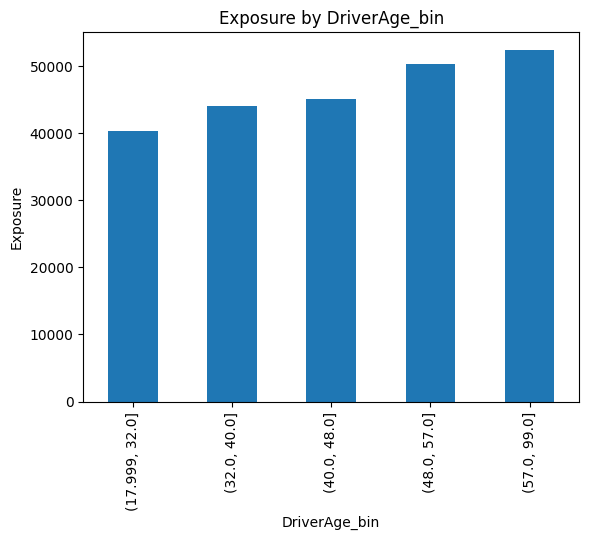

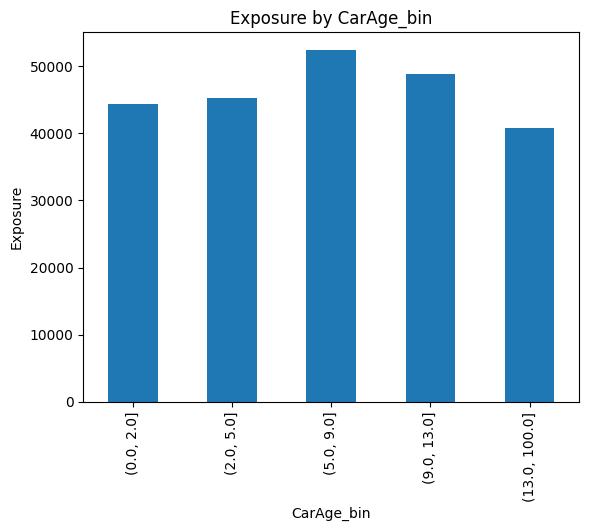

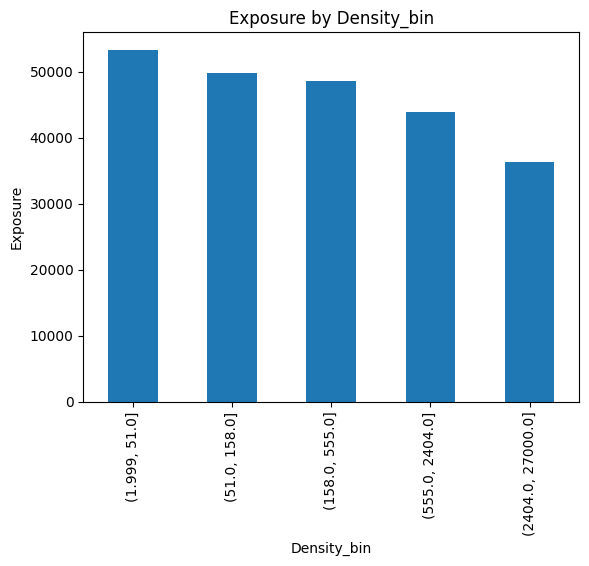

In [78]:
for binned_variable in binned_variables:
    df.groupby(binned_variable).sum()[exposure_name].plot.bar()
    plt.ylabel(exposure_name)
    plt.title(f'{exposure_name} by {binned_variable}')
    plt.show()

# 3. Modelling <a name="three"></a>

For each policyholder $i$, we can identify the 

- $N_{i}$, the number of claims during the period/exposure $d_{i}$ (the duration over which the contract is force)
- $L_{i}$, the aggregate loss related to $N_{i}$ claims

The pure premium or risk premium is often denoted as $\pi_{i}$ and broken down as follow:

$\pi_{i}$ = $\mathbb{E}[\frac{N_{i}}{d_{i}}]. \mathbb{E}[\frac{L_{i}}{N_{i}}|N_{i} > 0] = \underbrace{\mathbb{E}[F_{i}]}_\text{frequency}.\underbrace{\mathbb{E}[Sev_{i}]}_\text{severity}$
***

Let set $\mathbf{x_{i}} = (x_{i1}, \cdots , x_{ip})'$

$\mathbb{E}[N_{i} | \mathbf{x_{i}}] = d_{i} exp(\beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})) $

$N_{i} \sim Poi(d_{i} exp(\beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})) $

***

The score of the linear predictor is defined as follow:
    
$score_{i} = \beta_{0} + \sum_{j=1}^{p}(\beta_{j}x_{ij})$

The expected claim frequency for policyholder $i$ is: $d_{i}exp(score_{i})$

$\hat{\beta_{0}}, \hat{\beta_{1}}, \cdots, \hat{\beta_{p}}$  are the estimates of the regression coefficients $\beta_{0}, \beta_{1}, \cdots, \beta_{p} $

$\hat{\lambda_{i}} = d_{i}exp(\hat{score_{i}})$

$\hat{\lambda_{i}} = d_{i}exp(\hat{\beta_{0}} + \sum_{j=1}^{p}(\hat{\beta_{j}}x_{ij}))$

is the predicted number of claims for policyholder $i$

## 3.1 Regression Tree <a name="three-one"></a>

In [79]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, claim_frequency, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=X[nb_claims_name])


In [80]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, 
                                                    test_size=VAL_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                   stratify=x_train_val[nb_claims_name])

In [81]:
exp_train, exp_val, exp_test = x_train[exposure_name], x_val[exposure_name], x_test[exposure_name]

In [82]:
x_val

,ClaimNb,Exposure,power_d,power_e,power_f,power_g,power_h,power_i,power_j,power_k,...,driverage_bin_40_to_48,driverage_bin_48_to_57,carage_bin_2_to_5,carage_bin_5_to_9,carage_bin_9_to_13,carage_bin_13_to_100,density_bin_51_to_150,density_bin_150_to_555,density_bin_555_to_2404,density_bin_2404_27000
92789,0,0.57,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
280287,0,0.72,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
55112,0,0.01,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
39710,0,1.00,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
82517,0,0.45,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77317,0,0.02,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
126264,0,1.00,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
16429,0,1.00,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
319537,0,0.04,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [83]:
x_train = x_train.drop(columns=[nb_claims_name, exposure_name])
x_val = x_val.drop(columns=[nb_claims_name, exposure_name])
x_test = x_test.drop(columns=[nb_claims_name, exposure_name])

### 3.1.1 Regression Tree - No optimization <a name="three-one-one"></a>

In [84]:
logging_optimizer_decorator_factory = LoggingOptimizerScikitLearn()

In [85]:
DecisionTreeRegressorLogger = logging_optimizer_decorator_factory(DecisionTreeRegressor)

In [86]:
poisson_tree_params = {'criterion':'poisson','max_depth':3, 'ccp_alpha':0}
poisson_tree, results = DecisionTreeRegressorLogger('reg_tree_without_opt',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                    False,
                                     **poisson_tree_params)

In [87]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"


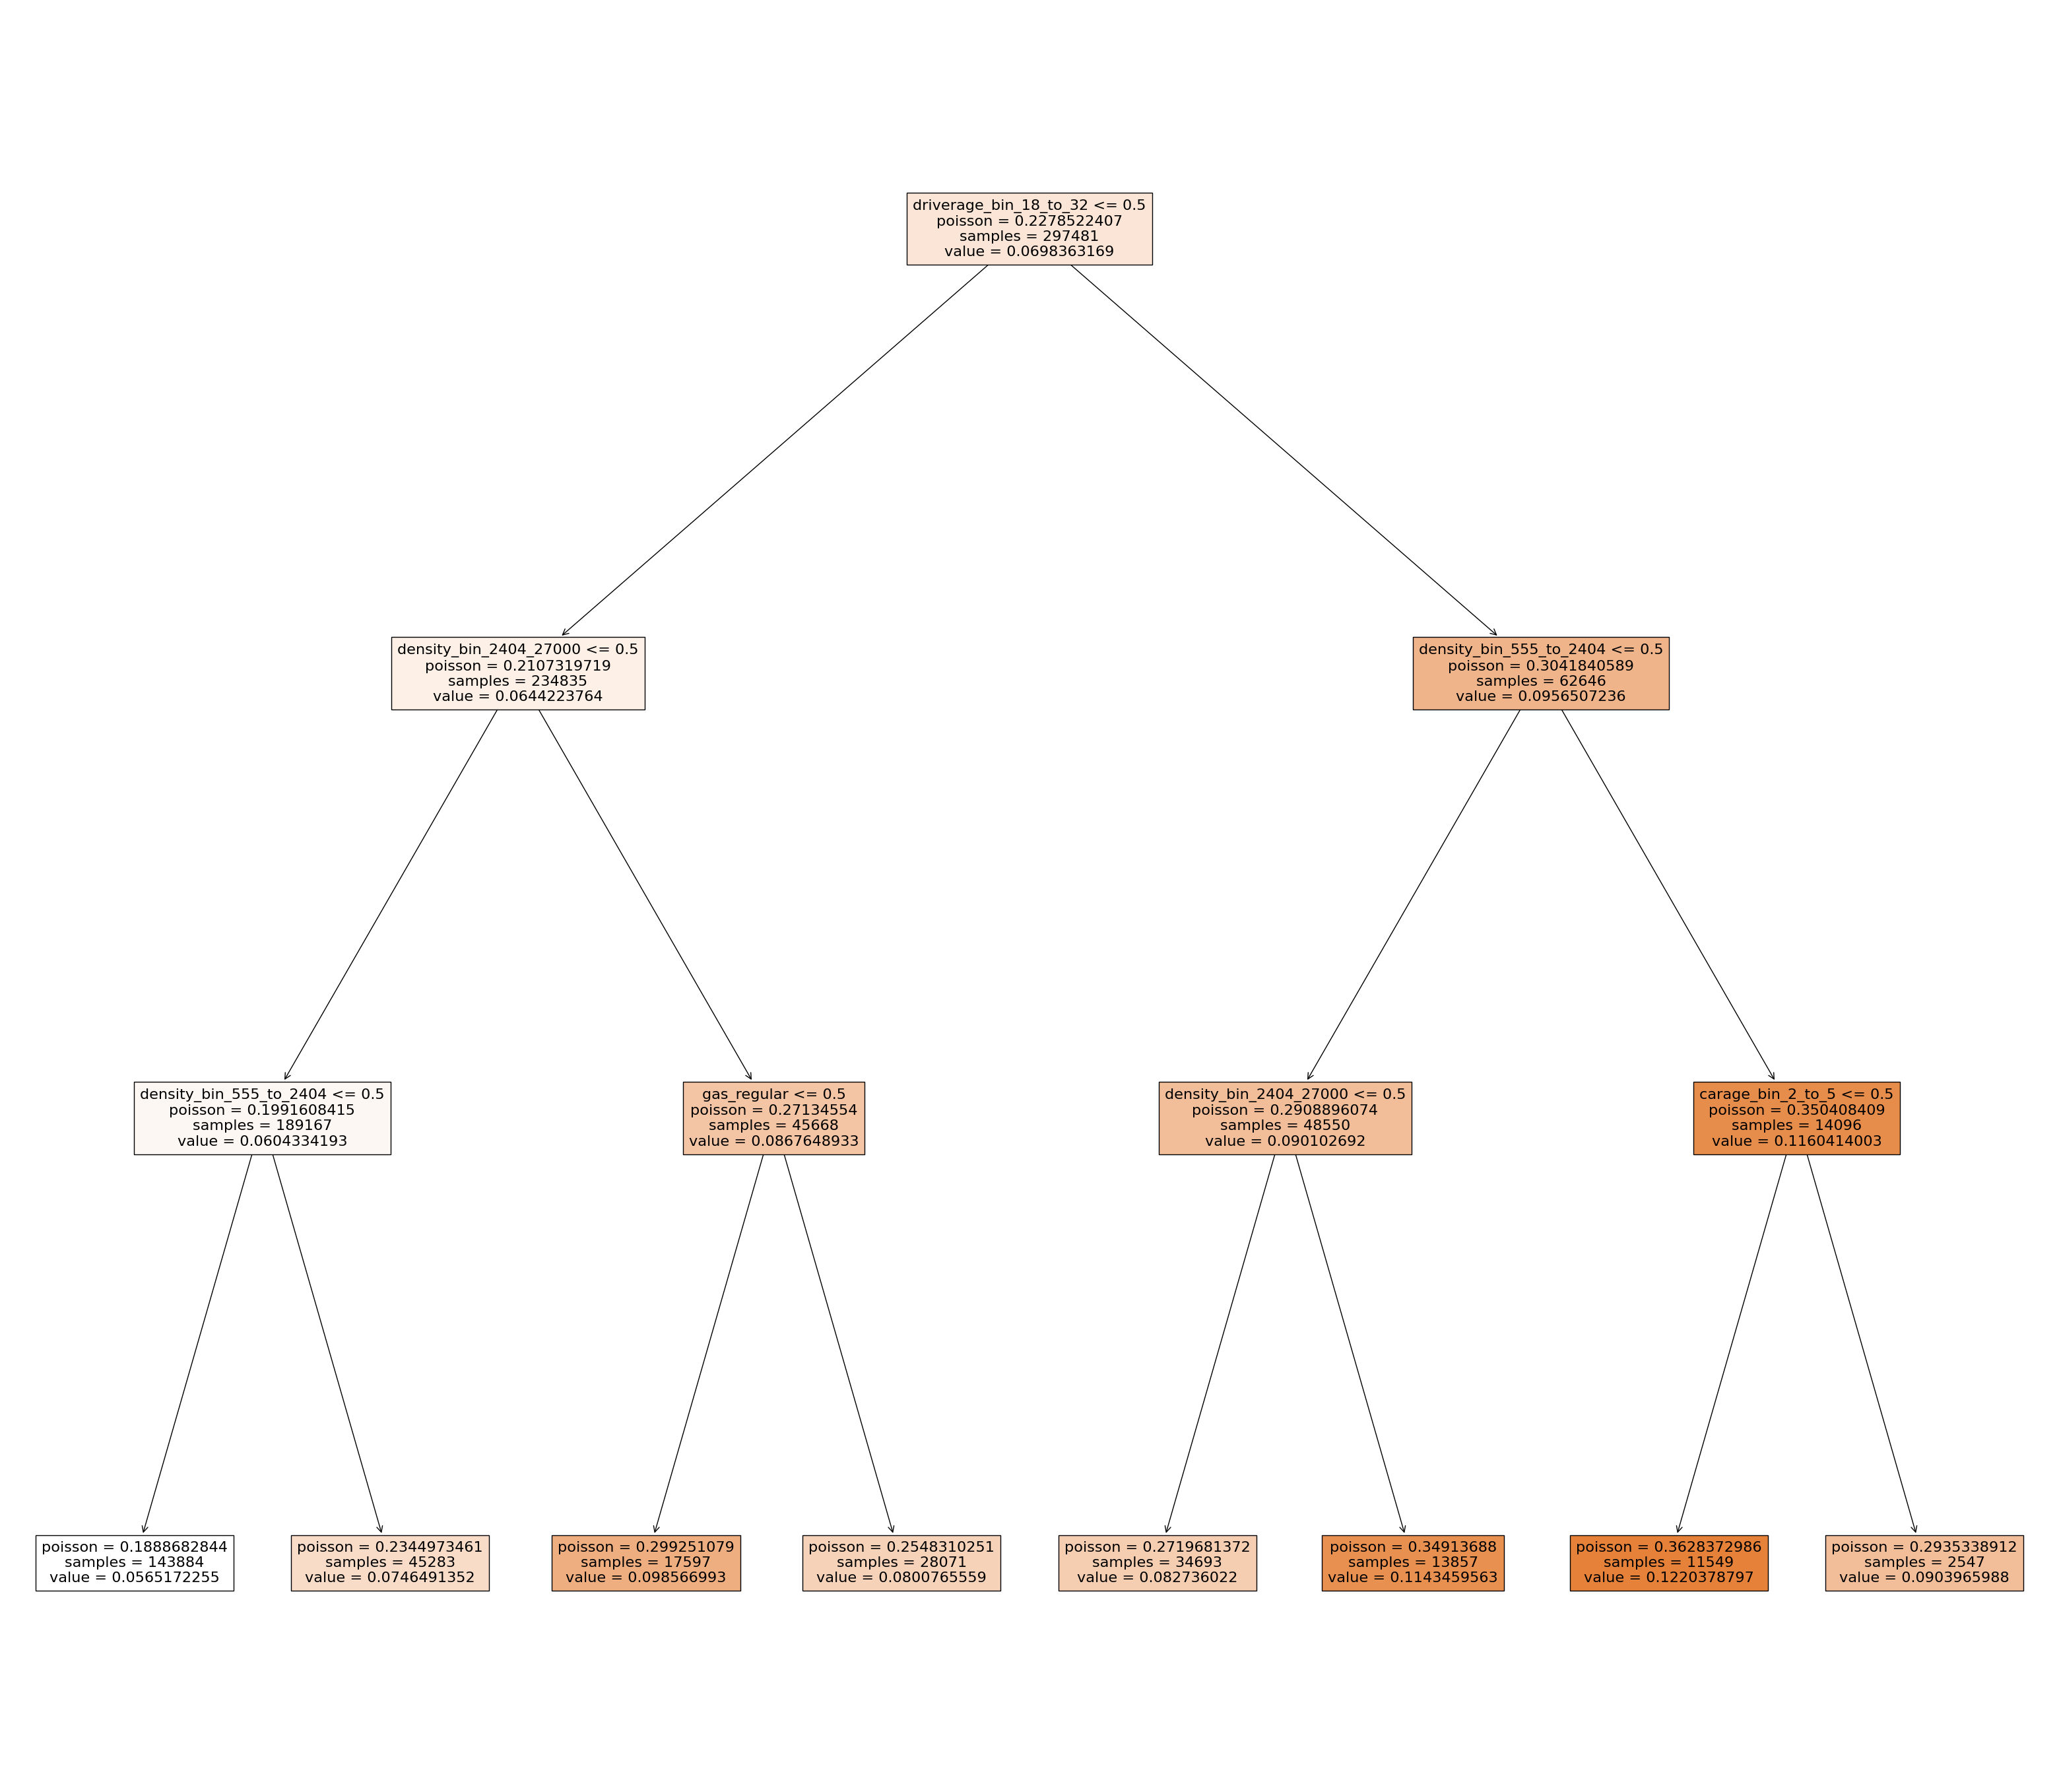

In [88]:
fig = plt.figure(figsize=(40,35))
_=tree.plot_tree(poisson_tree, 
                   feature_names=x_train.columns,  
                   filled=True,
                precision=10)

In [89]:
print(tree.export_text(poisson_tree))

|--- feature_27 <= 0.50
|   |--- feature_38 <= 0.50
|   |   |--- feature_37 <= 0.50
|   |   |   |--- value: [0.06]
|   |   |--- feature_37 >  0.50
|   |   |   |--- value: [0.07]
|   |--- feature_38 >  0.50
|   |   |--- feature_17 <= 0.50
|   |   |   |--- value: [0.10]
|   |   |--- feature_17 >  0.50
|   |   |   |--- value: [0.08]
|--- feature_27 >  0.50
|   |--- feature_37 <= 0.50
|   |   |--- feature_38 <= 0.50
|   |   |   |--- value: [0.08]
|   |   |--- feature_38 >  0.50
|   |   |   |--- value: [0.11]
|   |--- feature_37 >  0.50
|   |   |--- feature_31 <= 0.50
|   |   |   |--- value: [0.12]
|   |   |--- feature_31 >  0.50
|   |   |   |--- value: [0.09]



In [90]:
def plot_feature_importance_for_tree_based_methods(tree:sklearn.tree) -> None:
    feature_importances = {}
    for feature_name, feature_importance in zip(tree.feature_names_in_, tree.feature_importances_):
        if feature_importance>0:
            feature_importances[feature_name] = feature_importance
    sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item : item[1], reverse=False))
    plt.barh(list(sorted_feature_importances.keys()), list(sorted_feature_importances.values()))
    plt.xlabel('Sum of reduced variance induced by a set of feature splits')
    plt.title('Features importance')

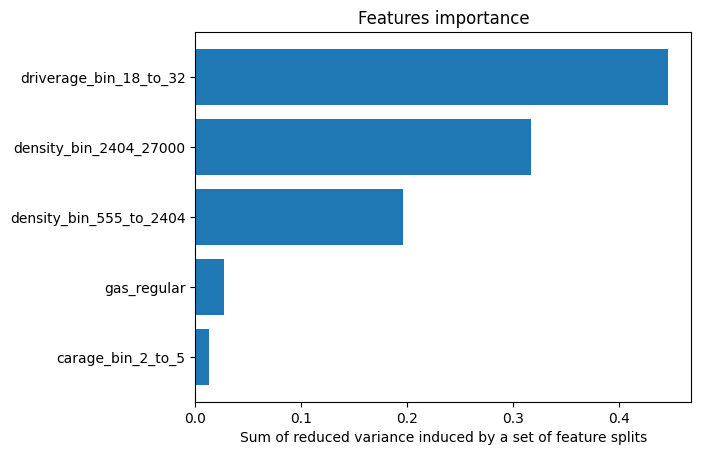

In [91]:
plot_feature_importance_for_tree_based_methods(poisson_tree)

- Here, we see which splits of bin variables contributed the most to the reduction of the initial deviance 
- The bin `driverage_bin_18_to_32` is deemed to be the most important

Now, we will perform the same analysis but instead of choosing the default hyperparameter values, we randomnly search the best `max_depth` and `ccp_alpha` hyperparameter.

We will try to do it using

1. the built-in HyperOpt optimized of scikit-learn (when provided with the Poisson deviance loss function weighted by the exposure)
2. Our own customized hyperparameter optimization

Indeed, we decided to code our own solution as the scikit learn lead to numerical errors (see scores null values below)

### 3.1.2 Regression Tree - Random Search - Scikit Learn <a name="three-one-two"></a>

In [92]:
step = 0.01
param_grid = {'max_depth': [7],
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,1+step, step))}
meta_hyperparams = {'estimator':DecisionTreeRegressor(), 
                    'param_distributions':param_grid,
                    'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

In [93]:
RandomSearchLogger = logging_optimizer_decorator_factory(RandomizedSearchCV)

In [94]:
reg_tree_opt_rs_scikit, results = RandomSearchLogger('reg_tree_opt_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

In [95]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"


### 3.1.3 Regression Tree - Halving Random Search - Scikit Learn <a name="three-one-three"></a>

In [96]:
meta_hyperparams = {'estimator':DecisionTreeRegressor(), 
                    'param_distributions':param_grid,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True}

In [97]:
HalvingRandomSearchLogger = logging_optimizer_decorator_factory(HalvingRandomSearchCV)

In [99]:
reg_tree_opt_halving_rs_scikit, results = HalvingRandomSearchLogger('reg_tree_opt_halving_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

In [100]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"
reg_tree_opt_halving_rs_scikit,0.46,0.46,0.24,0.07,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"


### 3.1.4 Regression Tree - Random Search Customed  <a name="three-one-four"></a>

In [ ]:
df_train = pd.concat([x_train, y_train, exp_train], axis=1)

In [ ]:
step = 0.00001
param_grid = {'max_depth': list(np.arange(4,8)),
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,0.0003+step, step))}

In [ ]:
def fitting_regression_tree(params_model: Dict[str, Any],
                            x_train: pd.DataFrame,
                            y_train: Union[pd.Series, pd.DataFrame],
                            exp_train: Union[pd.Series, pd.DataFrame]) -> sklearn.tree._classes.DecisionTreeRegressor:
    tree = DecisionTreeRegressor(**params_model)
    tree.fit(x_train, y_train, sample_weight=exp_train)
    return tree

In [ ]:
hyperparams_space = param_grid
model_fit_func = fitting_regression_tree
loss_function = mean_poisson_deviance
params_to_record = None
limit_time = 180
max_iter = 100
is_debug = False
params_to_record = ['ccp_alpha', 'max_depth']

In [ ]:
start_time = time.time()
cv_results, best_models = run_hyperopt_for_tree_based_methods(df_train=df_train,
                                   hyperparams_space=param_grid,
                                   model_fit_func=model_fit_func,
                                   loss_function=loss_function,
                                   params_to_record=params_to_record,
                                   exposure_name=exposure_name,
                                   target_name = claim_frequency_name,
                                   limit_time=limit_time,
                                   max_iter=max_iter,
                                   is_debug=False)
opt_time_custom_tree_opt = (time.time() - start_time)/60

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

In [ ]:
sorted_results = cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss'], ascending=True)
sorted_results.reset_index(inplace=True, drop=True)
sorted_results.head(5)

In [ ]:
tree_opt_cv_std_loss = sorted_results.loc[0,'cv_std_loss']

In [ ]:
best_result = cv_results.loc[sorted_results.first_valid_index(), ['ccp_alpha', 'max_depth']]
best_result

In [ ]:
poisson_tree_opt = DecisionTreeRegressor(criterion='poisson', 
                                         max_depth=best_result.max_depth, 
                                         ccp_alpha=best_result.ccp_alpha, 
                                         random_state=RANDOM_STATE)
poisson_tree_opt.fit(x_train, y_train, sample_weight=exp_train)

In [ ]:
fig = plt.figure(figsize=(20,20))
_=tree.plot_tree(poisson_tree_opt, 
                   feature_names=x_train.columns,  
                   filled=True,
                precision=10)


In [ ]:
print(tree.export_text(poisson_tree_opt))

In [ ]:
plot_feature_importance_for_tree_based_methods(poisson_tree_opt)

This time, the feature importances results are much closer to the GLM realized in the previous study with the age and district bins being the most important.

Next, we will look at the loss deviance

In [ ]:
dev_poiss_tree_opt_train = mean_poisson_deviance(y_train, poisson_tree_opt.predict(x_train),sample_weight=exp_train)
dev_poiss_tree_opt_test = mean_poisson_deviance(y_test, poisson_tree_opt.predict(x_test),sample_weight=exp_test)

results['dev_poiss_train']['tree_custom_opt'] = dev_poiss_tree_opt_train
results['dev_poiss_test']['tree_custom_opt'] = dev_poiss_tree_opt_test
results['cv_std']['tree_custom_opt'] = tree_opt_cv_std_loss
results['optimization_time']['tree_custom_opt'] = opt_time_custom_tree_opt
results['best_params']['tree_custom_opt'] = best_result.to_dict()

### 3.1.5 Regression Tree - Bayesian optimization - Mango  <a name="three-one-five"></a>

In [101]:
# Bayesian hyperopt with mango https://towardsdatascience.com/mango-a-new-way-to-make-bayesian-optimisation-in-python-a1a09989c6d8

In [102]:
# First step: define the search space of your algorithm
# usage of range instead of uniform to ensure integers
param_space = { 'criterion':['poisson'],
               'splitter':['best'],
                'max_depth': [7],
#                'min_samples_split': range(int(0.01*x_train.shape[0]), int(0.1*x_train.shape[0])),
#                'min_samples_leaf': range(int(0.001*x_train.shape[0]), int(0.1*x_train.shape[0])),
               'max_features': ["auto"],
               'ccp_alpha': np.arange(0,1, 0.1, dtype=np.int64),
               }

In [103]:
def objective(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = DecisionTreeRegressor(**hyperparams)
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results

In [104]:
meta_params = {'param_dict':param_space,
                'objective':objective,
               'conf_dict':{'num_iteration':N_ITER, 'initial_random':RANDOM_STATE}
              }

In [105]:
logging_mango_optimizer_decorator_factory = LoggingOptimizerMango()

In [106]:
BayesianOptimizerLogger = logging_mango_optimizer_decorator_factory(Tuner)

In [107]:
reg_tree_bayesian_opt_mango, results = BayesianOptimizerLogger('reg_tree_bayesian_opt_mango',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     DecisionTreeRegressor,
                                    **meta_params)

  0%|          | 0/1 [00:00<?, ?it/s]

In [108]:
pd.DataFrame(results).sort_values(by='dev_poiss_test', ascending=True)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_bayesian_opt_mango,0.45,0.45,NaN,0.43,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0}"
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"
reg_tree_opt_halving_rs_scikit,0.46,0.46,0.24,0.07,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"


***Key takeaway:***



## 3.2 Random Forest<a name="three-two"></a>

As we have seen during the course, the random forest estimator has the same bias as the tree except that it has a lower deviance due to the errors decorrelation of the aggregation of the multiple trees. 

We except to have more stable results with lower variance, lower deviance, however it comes with a cost, we need to tune an additional parameter:the `n_estimators`

### 3.2.1 Random Forest - No optimization <a name="three-two-one"></a>

In [109]:
n_estimators = 500
criterion='poisson'
max_depth = 3
RANDOM_STATE=RANDOM_STATE
ccp_alpha=0.0
params_model = {'n_estimators':n_estimators,
                'criterion':criterion,
                'max_depth':max_depth,
                'random_state':RANDOM_STATE,
                'ccp_alpha':ccp_alpha,
               }

In [110]:
RandomForestRegressorLogger = logging_optimizer_decorator_factory(RandomForestRegressor)
rf, results = RandomForestRegressorLogger('rf_without_opt',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                    False,
                                     **params_model)

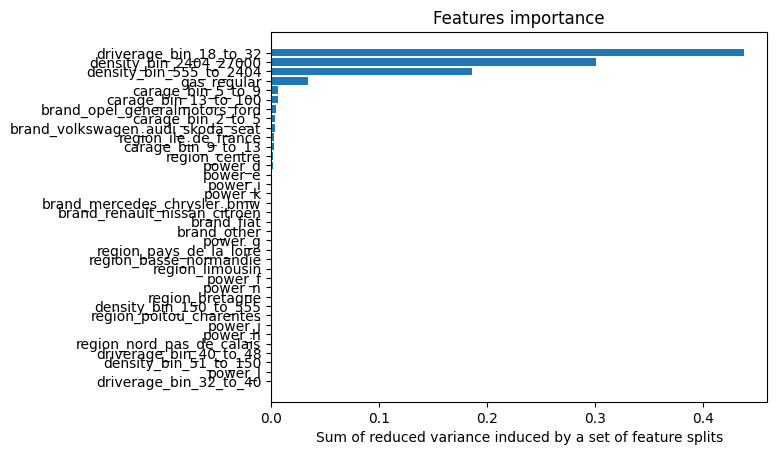

In [111]:
plot_feature_importance_for_tree_based_methods(rf)

In [112]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"
reg_tree_opt_halving_rs_scikit,0.46,0.46,0.24,0.07,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.45,0.45,NaN,0.43,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0}"
rf_without_opt,0.45,0.45,NaN,2.07,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"


### 3.2.2 Random Forest - Random Search Scikit Learn optimization <a name="three-two-two"></a>

In [113]:
param_grid = {'n_estimators':list(np.arange(10, 500, 10)),    
                'max_depth': [7],
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,0.0003+step, step))
             }
meta_hyperparams = {'estimator':RandomForestRegressor(), 
                    'param_distributions':param_grid,
                    'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }
RandomSearchLogger = logging_optimizer_decorator_factory(RandomizedSearchCV)
rf_opt_rs_scikit, results = RandomSearchLogger('rf_opt_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

In [122]:
rf_opt_rs_scikit_estimator = RandomForestRegressor(**rf_opt_rs_scikit.best_params_)
rf_opt_rs_scikit_estimator.fit(x_train, y_train)

RandomForestRegressor(criterion='poisson', max_depth=7, n_estimators=480,
                      random_state=42)

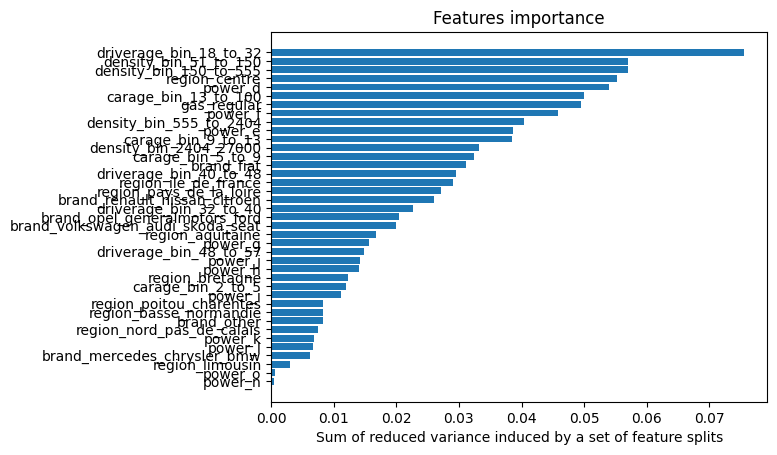

In [123]:
plot_feature_importance_for_tree_based_methods(rf_opt_rs_scikit_estimator)

In [124]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"
reg_tree_opt_halving_rs_scikit,0.46,0.46,0.24,0.07,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.45,0.45,NaN,0.43,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0}"
rf_without_opt,0.45,0.45,NaN,2.07,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
rf_opt_rs_scikit,0.44,0.45,0.04,22.94,"{'random_state': 42, 'n_estimators': 480, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"


### 3.2.3 Random Forest - Halving Random Search Scikit Learn optimization <a name="three-two-three"></a>

In [126]:
meta_hyperparams = {'estimator':RandomForestRegressor(), 
                    'param_distributions':param_grid,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

In [127]:
HalvingRandomSearchLogger = logging_optimizer_decorator_factory(HalvingRandomSearchCV)
rf_opt_halving_rs_scikit, results = HalvingRandomSearchLogger('rf_opt_halving_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

In [129]:
rf_opt_halving_rs_scikit_estimator = RandomForestRegressor(**rf_opt_halving_rs_scikit.best_params_)
rf_opt_halving_rs_scikit_estimator.fit(x_train, y_train)

RandomForestRegressor(criterion='poisson', max_depth=7, n_estimators=260,
                      random_state=42)

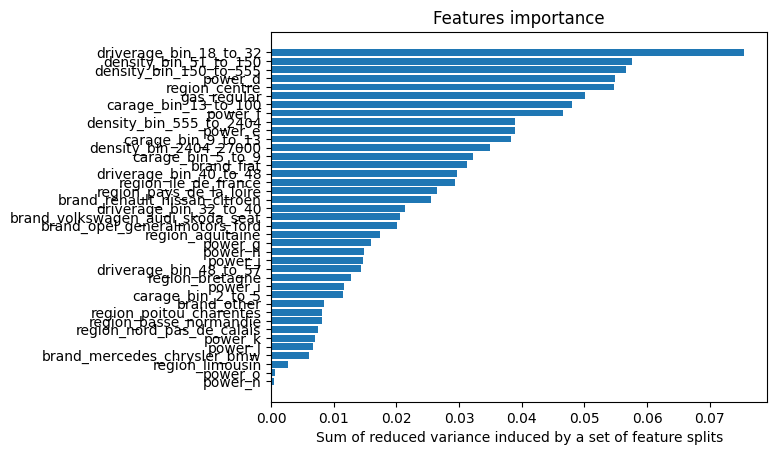

In [130]:
plot_feature_importance_for_tree_based_methods(rf_opt_halving_rs_scikit_estimator)

In [131]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"
reg_tree_opt_halving_rs_scikit,0.46,0.46,0.24,0.07,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.45,0.45,NaN,0.43,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0}"
rf_without_opt,0.45,0.45,NaN,2.07,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
rf_opt_rs_scikit,0.44,0.45,0.04,22.94,"{'random_state': 42, 'n_estimators': 480, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.44,0.45,0.12,3.52,"{'random_state': 42, 'n_estimators': 260, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"


### 3.2.4 Random Forest -  Bayesian Mango optimization <a name="three-two-four"></a>

In [133]:
def objective(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = RandomForestRegressor(**hyperparams)
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results
meta_params = {'param_dict':param_grid,
                'objective':objective,
               'conf_dict':{'num_iteration':N_ITER, 'initial_random':RANDOM_STATE}
              }
logging_mango_optimizer_decorator_factory = LoggingOptimizerMango()
BayesianOptimizerLogger = logging_mango_optimizer_decorator_factory(Tuner)
rf_bayesian_opt_mango, results = BayesianOptimizerLogger('rf_bayesian_opt_mango',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     RandomForestRegressor,
                                    **meta_params)

  0%|          | 0/1 [00:00<?, ?it/s]

In [134]:
#plot_feature_importance_for_tree_based_methods(rf_bayesian_opt_mango)

AttributeError: 'Tuner' object has no attribute 'feature_names_in_'

In [138]:
pd.DataFrame(results).sort_values(by='dev_poiss_test',ascending=True)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
rf_opt_halving_rs_scikit,0.44,0.45,0.12,3.52,"{'random_state': 42, 'n_estimators': 260, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_rs_scikit,0.44,0.45,0.04,22.94,"{'random_state': 42, 'n_estimators': 480, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
reg_tree_bayesian_opt_mango,0.45,0.45,NaN,0.43,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0}"
rf_without_opt,0.45,0.45,NaN,2.07,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
rf_bayesian_opt_mango,0.46,0.46,NaN,93.76,"{'random_state': 42, 'n_estimators': 220, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.01}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"
reg_tree_opt_halving_rs_scikit,0.46,0.46,0.24,0.07,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"


### 3.2.5 Random Forest - Random Search customized optimization <a name="three-two-five"></a>

In [ ]:
%%script false
def random_forest_fit_func(params_model: Dict[str, Any],
                            x_train: pd.DataFrame,
                            y_train: Union[pd.Series, pd.DataFrame],
                            exp_train: Union[pd.Series, pd.DataFrame]) -> sklearn.ensemble.RandomForestRegressor:
    rf = RandomForestRegressor(**params_model)
    rf.fit(x_train, y_train, sample_weight=exp_train)
    return rf

In [ ]:
%%script false
step = 0.00001
param_grid = {'n_estimators':list(np.arange(10, 500, 10)),    
                'max_depth': list(np.arange(3,8)),
               'random_state':[RANDOM_STATE],
              'criterion': ['poisson'],
              'ccp_alpha': list(np.arange(0,0.0003+step, step))
             }
hyperparams_space = param_grid
model_fit_func = random_forest_fit_func
loss_function = mean_poisson_deviance
limit_time = 180
max_iter = 100
is_debug = False
params_to_record = ['ccp_alpha', 'max_depth', 'n_estimators']
cv_results, best_models = run_hyperopt_for_tree_based_methods(df_train=df_train,
                                   hyperparams_space=param_grid,
                                   model_fit_func=model_fit_func,
                                   loss_function=loss_function,
                                   params_to_record=params_to_record,
                                   exposure_name=exposure_name,
                                   target_name = claim_frequency_name,
                                   limit_time=limit_time,
                                   max_iter=max_iter,
                                   is_debug=False)

In [ ]:
%%script false
sorted_results = cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss'], ascending=True)
sorted_results

In [ ]:
%%script false
best_result = cv_results.loc[sorted_results.first_valid_index(), ['ccp_alpha', 'max_depth', 'n_estimators', 'cv_std_loss']]
best_result

In [ ]:
%%script false
rf_opt = RandomForestRegressor(criterion='poisson', 
                                         max_depth=best_result.max_depth, 
                                         ccp_alpha=best_result.ccp_alpha, 
                                         n_estimators=best_result.n_estimators, 
                                         random_state=RANDOM_STATE)
rf_opt.fit(x_train, y_train, sample_weight=exp_train)

In [ ]:
%%script false
plot_feature_importance_for_tree_based_methods(rf_opt)

In [ ]:
%%script false
dev_poiss_rf_opt_train = mean_poisson_deviance(y_train, rf_opt.predict(x_train),sample_weight=exp_train)
dev_poiss_rf_opt_test = mean_poisson_deviance(y_test, rf_opt.predict(x_test),sample_weight=exp_test)

results['dev_poiss_train']['rf_opt'] = dev_poiss_rf_opt_train
results['dev_poiss_test']['rf_opt'] = dev_poiss_rf_opt_test
results['cv_std']['rf_opt'] = best_result.cv_std_loss

## 3.3 Gradient Boosting  <a name="three-three"></a>

### 3.3.1 Gradient Boosting - No optimization  <a name="three-three-one"></a>

In [139]:
n_estimators = 500
objective='count:poisson'
monotone_constraints = tuple([0 for _ in range(x_train.shape[1])])
max_depth = 7
learning_rate = 0.01
eta = 0.3
base_score = y_train.mean()
params_model = {'n_estimators':n_estimators,
                'objective':objective,
                'eta':eta,
                #'monotone_constraints':monotone_constraints,
                'max_depth':max_depth,
                'learning_rate':learning_rate,
                'base_score':base_score,
                'seed':RANDOM_STATE
               }

In [140]:
XGBRegressorLogger = logging_optimizer_decorator_factory(xgb.XGBRegressor)
xgb_without_opt, results = XGBRegressorLogger('xgb_without_opt',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                    False,
                                     **params_model)

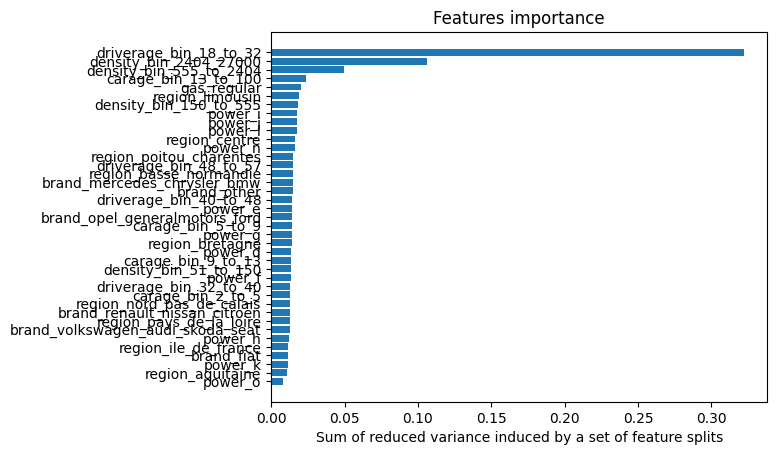

In [141]:
plot_feature_importance_for_tree_based_methods(xgb_without_opt)

In [142]:
pd.DataFrame(results)

,dev_poiss_train,dev_poiss_test,cv_std,optimization_time,best_params
reg_tree_without_opt,0.45,0.45,NaN,0.01,"{'criterion': 'poisson', 'max_depth': 3, 'ccp_alpha': 0}"
reg_tree_opt_rs_scikit,0.46,0.46,0.04,0.08,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.62}"
reg_tree_opt_halving_rs_scikit,0.46,0.46,0.24,0.07,"{'random_state': 42, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.24}"
reg_tree_bayesian_opt_mango,0.45,0.45,NaN,0.43,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0}"
rf_without_opt,0.45,0.45,NaN,2.07,"{'n_estimators': 500, 'criterion': 'poisson', 'max_depth': 3, 'random_state': 42, 'ccp_alpha': 0.0}"
rf_opt_rs_scikit,0.44,0.45,0.04,22.94,"{'random_state': 42, 'n_estimators': 480, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_opt_halving_rs_scikit,0.44,0.45,0.12,3.52,"{'random_state': 42, 'n_estimators': 260, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.0}"
rf_bayesian_opt_mango,0.46,0.46,NaN,93.76,"{'random_state': 42, 'n_estimators': 220, 'max_depth': 7, 'criterion': 'poisson', 'ccp_alpha': 0.01}"
xgb_without_opt,0.44,0.45,NaN,1.28,"{'n_estimators': 500, 'objective': 'count:poisson', 'eta': 0.3, 'max_depth': 7, 'learning_rate': 0.01, 'base_score': 0.11785594655122446, 'seed': 42}"


### 3.3.2 Gradient Boosting - Random Search Scikit Learn optimization  <a name="three-three-two"></a>

In [148]:
step = 0.00001
param_grid = {'n_estimators':list(np.arange(10, 500, 10)),
                'criterion':[objective],
                'ccp_alpha':list(np.arange(0, 1, step)),
#                 'eta':list(np.arange(0,0.5+step, step)),
                #'monotone_constraints':monotone_constraints,
                'max_depth':list(np.arange(3,8)),
                'learning_rate':[learning_rate],
#                 'base_score':[base_score],
                'random_state':[RANDOM_STATE]
               }
meta_hyperparams = {'estimator':GradientBoostingRegressor, 
                    'param_distributions':param_grid,
                    'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

RandomSearchLogger = logging_optimizer_decorator_factory(RandomizedSearchCV)

In [149]:
xgb_opt_rs_scikit, results = RandomSearchLogger('xgb_opt_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

In [ ]:
plot_feature_importance_for_tree_based_methods(xgb_opt_rs_scikit)

In [ ]:
pd.DataFrame(xgb_opt_rs_scikit)

### 3.3.3 Gradient Boosting - Halving Random Search Scikit Learn optimization  <a name="three-three-three"></a>

In [152]:
meta_hyperparams = {'estimator':GradientBoostingRegressor, 
                    'param_distributions':param_grid,
#                     'n_iter':N_ITER_SKLEARN_HYPEROPT,
                    'scoring':'neg_mean_poisson_deviance',
                    'refit':True
                   }

In [153]:
HalvingRandomSearchLogger = logging_optimizer_decorator_factory(HalvingRandomSearchCV)
xgb_opt_halving_rs_scikit, results = HalvingRandomSearchLogger('xgb_opt_halving_rs_scikit',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     True,
                                    **meta_hyperparams)

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

In [ ]:
plot_feature_importance_for_tree_based_methods(xgb_opt_halving_rs_scikit)

In [ ]:
pd.DataFrame(results)

### 3.3.4 Gradient Boosting - Bayesian Mango optimization  <a name="three-three-four"></a>

In [160]:
def objective(hyperparameters:Dict[str, Any]) -> List[float]:
    global x_train, y_train, x_val, y_val, exp_train, exp_val
    
    results = []
    for hyperparams in hyperparameters:
        model = xgb.XGBRegressor(**hyperparams)
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val)
        error = mean_poisson_deviance(y_val, pred_val, sample_weight=exp_val)
        results.append(error)
    return results

param_grid = {'n_estimators':list(np.arange(10, 500, 10)),
                'objective':['count:poisson'],
#                 'ccp_alpha':list(np.arange(0, 1, step)),
                'eta':list(np.arange(0,0.5+step, step)),
                #'monotone_constraints':monotone_constraints,
                'max_depth':list(np.arange(3,8)),
                'learning_rate':[learning_rate],
#                 'base_score':[base_score],
                'seed':[RANDOM_STATE]
               }
meta_params = {'param_dict':param_grid,
                'objective':objective,
               'conf_dict':{'num_iteration':N_ITER, 'initial_random':RANDOM_STATE}
              }
logging_mango_optimizer_decorator_factory = LoggingOptimizerMango()
BayesianOptimizerLogger = logging_mango_optimizer_decorator_factory(Tuner)
xgb_bayesian_opt_mango, results = BayesianOptimizerLogger('xgb_bayesian_opt_mango',
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test, 
                                     exp_train,
                                     exp_test,
                                     xgb.XGBRegressor,
                                    **meta_params)

MemoryError: 

In [ ]:
plot_feature_importance_for_tree_based_methods(xgb_bayesian_opt_mango)

In [ ]:
pd.DataFrame(results)

### 3.3.5 Gradient Boosting - Random Search Customed optimization  <a name="three-three-five"></a>

In [ ]:
x_train.columns

In [ ]:
n_estimators = 500
objective='count:poisson'
monotone_constraints = tuple([0 for _ in range(x_train.shape[1])])
max_depth = 7
learning_rate = 0.01
eta = 0.3
base_score = y_train.mean()
params_model = {'n_estimators':n_estimators,
                'objective':objective,
                'eta':eta,
                #'monotone_constraints':monotone_constraints,
                'max_depth':max_depth,
                'learning_rate':learning_rate,
                'base_score':base_score,
                'seed':RANDOM_STATE
               }

In [ ]:
gbm = xgb.XGBRegressor(**params_model)
gbm.fit(x_train, y_train, sample_weight=exp_train)

In [ ]:
plot_feature_importance_for_tree_based_methods(gbm)

In [ ]:
dev_poiss_xgb_train = mean_poisson_deviance(y_train, gbm.predict(x_train),sample_weight=exp_train)
dev_poiss_xgb_test = mean_poisson_deviance(y_test, gbm.predict(x_test),sample_weight=exp_test)

results['dev_poiss_train']['xgb'] = dev_poiss_xgb_train
results['dev_poiss_test']['xgb'] = dev_poiss_xgb_test
results['cv_std']['xgb'] = np.nan 

In [ ]:
results

In [ ]:
def gradient_boosting_fit_func(params_model: Dict[str, Any],
                            x_train: pd.DataFrame,
                            y_train: Union[pd.Series, pd.DataFrame],
                            exp_train: Union[pd.Series, pd.DataFrame]) -> xgb.XGBRegressor:
    gbm = xgb.XGBRegressor(**params_model)
    gbm.fit(x_train, y_train, sample_weight=exp_train)
    return gbm

In [ ]:
step = 0.00001
param_grid = {'n_estimators':list(np.arange(10, 500, 10)),
                'objective':[objective],
                'eta':list(np.arange(0,0.5+step, step)),
                #'monotone_constraints':monotone_constraints,
                'max_depth':list(np.arange(3,8)),
                'learning_rate':[learning_rate],
                'base_score':[base_score],
                'seed':[RANDOM_STATE]
               }
hyperparams_space = param_grid
model_fit_func = gradient_boosting_fit_func
loss_function = mean_poisson_deviance
limit_time = 180
max_iter = 100
is_debug = False
params_to_record = ['max_depth', 'n_estimators', 'eta']
cv_results, best_models = run_hyperopt_for_tree_based_methods(df_train=df_train,
                                   hyperparams_space=param_grid,
                                   model_fit_func=model_fit_func,
                                   loss_function=loss_function,
                                   params_to_record=params_to_record,
                                   exposure_name=exposure_name,
                                   target_name = claim_frequency_name,
                                   limit_time=limit_time,
                                   max_iter=max_iter,
                                   is_debug=False)

In [ ]:
sorted_results = cv_results.sort_values(by=['cv_mean_loss', 'cv_std_loss'], ascending=True)
sorted_results

In [ ]:
best_result = cv_results.loc[sorted_results.first_valid_index(), ['max_depth', 'n_estimators', 'cv_std_loss', 'eta']]
best_result

In [ ]:
objective='count:poisson'
monotone_constraints = tuple([0 for _ in range(x_train.shape[1])])
learning_rate = 0.01
base_score = y_train.mean()
gbm_opt = xgb.XGBRegressor(n_estimators=best_result.n_estimators,
                           objective= objective,
                           max_depth=best_result.max_depth,
                           learning_rate=learning_rate,
                           eta=best_result.eta,
                           base_score=base_score)
gbm_opt.fit(x_train, y_train, sample_weight=exp_train)

In [ ]:
plot_feature_importance_for_tree_based_methods(gbm_opt)

In [ ]:
dev_poiss_gbm_opt_train = mean_poisson_deviance(y_train, gbm_opt.predict(x_train),sample_weight=exp_train)
dev_poiss_gbm_opt_test = mean_poisson_deviance(y_test, gbm_opt.predict(x_test),sample_weight=exp_test)

results['dev_poiss_train']['xgb_opt'] = dev_poiss_gbm_opt_train
results['dev_poiss_test']['xgb_opt'] = dev_poiss_gbm_opt_test
results['cv_std']['xgb_opt'] = best_result.cv_std_loss

In [ ]:
results

In [ ]:
results_df = pd.DataFrame.from_dict(results)

In [ ]:
results_df.sort_values(by=['dev_poiss_test']).style.background_gradient(cmap='coolwarm')

*** Conclusion ***

Because of:

1. the more consistent results in terms of variable importance
2. the lower deviance score on test set
3. the more stable deviance scores on cv sets.

Gradient Boosting is deemed to be outperforming both regression trees and random forest algorithm in this particular case.